# Convolutional Neural Networks

Neural networks on image processing tasks are not realisitic due to the 2D representation of digital image and the massive amount of neurons/weights in a fully connected network. Also, the structual knowledge has not been taken advantage of by the conventional MLP, which treats pixels separately. **CNN** prorvides a concise way to learn a relatively computationally inexpensive representation of an image and incorporates the interatcion between adjacent pixels, turning the image classification task into a linear-solvable problem. CNN layer is the earliest layer of a network and should follow 3 principals.
1. *Translation Invariance*: the layer should respond similarly to the same patch of pixels (features) regardless of the location.
2. *Locality*: the layer should focus on local regions not regarding remote patches.
3. Deeper layer should capture features across long-range. 

## Model Derivation
Let $X\in R^2$ be a 2D image and $H\in2$ be the representation matrix of the same shape. By tensor convention, $[X]_{i,j}$ and $[H]_{i,j}$ denote the pixel at location (i,j). In a fully connected network, the relationship between 2 matrices can be expressed as 
$$
[H]_{i,j} = [U]_{i,j} + \sum_a\sum_b[V]_{i,j,a,b}[X]_{i+a,j+b}
$$
where $U$ is the bias matrix and V is a 4D tensor. 

### Translation Invariance

Since the layer should not vary by the location (i, j), we should have $[V]_{i,j,a,b}=[V]_{a,b}$ and same for $U$.
$$
[H]_{i,j} = u + \sum_a\sum_b[V]_{a,b}[X]_{i+a,j+b}
$$

### Locality

The layer shoud disregard features far away from (i,j). For some $\Delta\in\mathbb{R}$, let $[V]_{a,b}=0$ for $|a|,|b|>\Delta$.
$$
[H]_{i,j} = u + \sum_{a=-\Delta}^\Delta\sum_{b=-\Delta}^\Delta[V]_{a,b}[X]_{i+a,j+b}
$$
where $\Delta$ is typically smaller than 10 in image processing context.

This is called a **convolutional layer** and $V$ is the **convolutional kernel**. After transformation, we introduces translation invariance and inductive bias into the training data. Such assumption should be met in order to achieve good training results. By the 3rd principle, deeper layers tend to be interleaved layers of nonlinearities and convolutional layers to generate more complex and larger representation of the image.

**Remark**
The derivation of a convolutional layer does not fully comply to the definition of *convolution*. Rather, it resembles a *cross-correlation*.

## Channels

Each "pixel" tend to be represented by 3 color channels, thus being a vector. Instead of $[X]_{i,j}$, we have $[X]_{i,j,k}$ and $[U]_{i,j,k}$, with an extra index for the multidimension data. The hidden representation can be conceived as convolutional maps being stack together, aka **feature maps**. 

$$
[H]_{i,j,d} = u + \sum_{a=-\Delta}^\Delta\sum_{b=-\Delta}^\Delta\sum_c[V]_{a,b,c,d}[X]_{i+a,j+b,c}
$$

Each feature map can be specialized to capture different representations, like edge and textures.

## Feature Map & Receptive Field

Feature map refers the output of a convolutional layer, while the receptive field refers to any element from the previous layer that has an impact on a single input of this layer.

## Padding

The size of a convolutional kernel has an impace on the output matrix, thus the prediction might not have the same shape as the original image. This is undesirable since we intend to say something on the original image. **Padding** is the common solution to manipulate the output dimension.

The output dimension is calculated as:
$$
(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)
$$
in many cases, we set $p_h=k_h-1$ and $p_w=k_w-1$ to retain the original dimention. For this reason, CNN commonly use kernels with odd height and width values to pad same number of rows and columns around the image.

## Stride

Stride is the number of steps taken by the sliding window function to compute the cross-correlation. Opposite to padding, stride effectively reduces the dimension of the output matrix. It is useful for giant image to save computation power.

The output dimension combing both stride and padding is:
$$
\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor\times\lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor
$$



## Multiple Output Channel
The actual input may be 3D or more rather than simly 2D. In this case the dimension may be $c_i \times h_X\times w_X$, with $c$ being the vector representation of the individual pixel. The convolutional layer can take advantage of the vector representation to output multiple feature maps, thus having dimension of $c_o \times c_i \times h_k \times w_k$. 

For each single output feature map, the convolution layer is applied to each input channel and linear aggregate the results to one feature map. For multiple-input-output feature map, this process is repeated for $c_o$ times with different parameters. 

The multiple output channels can be intuitively interpreted as different features.

## Pooling 

Convolutional layers yields coarser representation as it deepens, and can be very sensitive to the locations. To mitigate these effects, pooling is introduced. Pooling similarly uses the idea of sliding window but contains no parameter. Instead, it either computes average or maximum like image downsampling technique. 

## Code Realization
### Cross-Correlation 2D

In [1]:
import torch

def corr2d(X, K, stride=(1,1)):
    h,w = K.shape
    Y = torch.zeros((X.shape[0]-h+stride[0])//stride[0], (X.shape[1]-w+stride[1])//stride[1])
    for i in range(0, Y.shape[0]):
        for j in range(0, Y.shape[1]):
            Y[i,j] = (X[stride[0]*i:h+stride[0]*i, stride[1]*j:stride[1]*j+w] * K).sum()
    return Y

#Test
X = torch.tensor(
    [
        [0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]
    ]
)

K = torch.tensor(
    [
        [0, 1],
        [2, 3]
    ]
)

corr2d(X, K, (2,2))

tensor([[19.]])

### Cross-correlation with Multiple Input Channels

In [2]:
# pay attention to the way tensors are ordered

def corr2d_multi_in(X, K):
    return sum(corr2d(x,k) for x,k in zip(X,K))

def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K])

# Test
X = torch.randint(0, 10, (3, 10, 10))
K = torch.randint(0, 5, (3, 2, 2))
K_mult = torch.randint(0, 5, (3, 3, 2, 2))
print(f"Shape of 1-output Conv: {corr2d_multi_in(X, K).shape}")
print(f"Shape of multiple-output Conv: {corr2d_multi_in_out(X, K_mult).shape}")

Shape of 1-output Conv: torch.Size([9, 9])
Shape of multiple-output Conv: torch.Size([3, 9, 9])


### Pooling

In [3]:
def pool2d(X, pool_size, mode='max'):
    h,w = pool_size
    Y = torch.zeros(X.shape[0]-h+1, X.shape[1]-w+1)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i,j] = X[i:i+h, j:j+w].max()
            else:
                Y[i,j] = X[i:i+h, j:j+w].mean()
    return Y

X = torch.randint(0,2,(10,10), dtype=float)
pool2d(X, (2,2), mode='avg')

tensor([[0.5000, 0.7500, 0.7500, 0.5000, 0.7500, 0.5000, 0.2500, 0.5000, 0.2500],
        [0.5000, 0.5000, 0.7500, 0.5000, 0.2500, 0.2500, 0.2500, 0.5000, 0.5000],
        [0.5000, 0.2500, 0.2500, 0.2500, 0.2500, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.2500, 0.5000, 0.2500, 0.0000, 0.2500, 0.5000, 0.7500, 0.5000, 0.2500],
        [0.5000, 0.5000, 0.2500, 0.2500, 0.2500, 0.0000, 0.2500, 0.2500, 0.5000],
        [1.0000, 0.5000, 0.0000, 0.2500, 0.2500, 0.2500, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.2500, 0.2500, 0.5000, 0.5000, 0.5000, 0.5000, 0.7500, 0.7500],
        [0.2500, 0.5000, 0.5000, 0.5000, 0.5000, 0.2500, 0.2500, 0.5000, 0.7500],
        [0.5000, 1.0000, 0.5000, 0.2500, 0.5000, 0.2500, 0.2500, 0.2500, 0.5000]])

### Convolutional Layers


In [4]:
from torch import nn

class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### Example: Naive Edge Detection

Let $X$ be an image of an object, we wish to detect the vertical edge of the object. We first manually label the edges and then train a network with only a convolutional layer.

In [5]:
con = Conv2D((1,3))
X = torch.tensor([
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0]
])

def pad(X, pad_shape):
    Y = torch.zeros(X.shape[0] + pad_shape[0] * 2, X.shape[1] + pad_shape[1]*2)
    Y[pad_shape[0]:pad_shape[0]+X.shape[0], pad_shape[1]:pad_shape[1]+X.shape[0]] = X
    return Y

pad(X, (0,2))

tensor([[0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.]])

In [6]:
#Y = corr2d(pad(X,(0,1)), torch.tensor([[0,1,0]]))
Y = torch.zeros(5,5)
Y[:,0] = 1
Y[:,-1] = 1

In [7]:
for i in range(50):
    Y_hat = con(pad(X, (0,1)))
    l = (Y_hat - Y)**2
    con.zero_grad()
    l.sum().backward()
    con.weight.data[:] -= 0.01 * con.weight.grad
    con.bias.data[:] -= 0.01 * con.bias.grad

    if i%10 == 0:
        print(f"loss: {l.sum()}")
con.weight

loss: 25.25831413269043
loss: 2.728872776031494
loss: 0.6431670188903809
loss: 0.23694980144500732
loss: 0.12538889050483704


Parameter containing:
tensor([[ 0.1465, -1.0231,  0.1465]], requires_grad=True)

In [8]:
con(pad(X, (0,1)))

tensor([[ 0.9763, -0.0468,  0.0997, -0.0468,  0.9763],
        [ 0.9763, -0.0468,  0.0997, -0.0468,  0.9763],
        [ 0.9763, -0.0468,  0.0997, -0.0468,  0.9763],
        [ 0.9763, -0.0468,  0.0997, -0.0468,  0.9763],
        [ 0.9763, -0.0468,  0.0997, -0.0468,  0.9763]], grad_fn=<AddBackward0>)

After 20 rounds of optimization, we observe that the final result is close to what intend to learn.

### Proof of Concept: LeNet

In [9]:
import dl
import torchvision
from torchvision.transforms import ToTensor

class fashionMNISTLoader(dl.DataModule):
    def __init__(self, batch_size=32):
        self.save_hyperparameters()
        super().__init__()
        
    def get_dataloader(self, train=True):
        if train:
            data = torchvision.datasets.FashionMNIST(root='./', train=True, transform=ToTensor())
        else:
            data = torchvision.datasets.FashionMNIST(root='./', train=False, transform=ToTensor())
        self.num_trian = len(data)
        loader = torch.utils.data.DataLoader(data, batch_size=self.batch_size)
        for X,y in loader:
            yield X, y


In [10]:
class LeNet(dl.Module):
    def __init__(self, eta=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Conv2d(1,6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120), nn.Sigmoid(),
            nn.Linear(120, 84), nn.Sigmoid(),
            nn.Linear(84, num_classes)
        )

        for each in self.net:
            if type(each) == nn.Linear or type(each) == nn.Conv2d:
                nn.init.xavier_normal_(each.weight)
    
    def configure_optimizers(self):
        return dl.SGD(
            [module.weight for module in self.net if type(module) in [nn.Conv2d, nn.Linear]],
            self.eta
        )

    def loss(self, y_hat, y):
        return nn.functional.cross_entropy(y_hat, y)

In [11]:
trainer = dl.Trainer(max_epochs=10)
data = fashionMNISTLoader(batch_size=32)
model = LeNet()
trainer.fit(model, data)

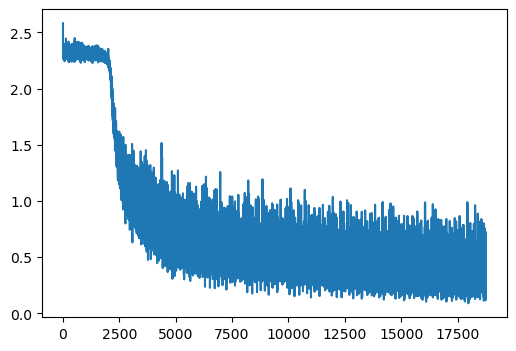

In [12]:
trainer.plot_loss()

In [13]:
data = torchvision.datasets.FashionMNIST(root='./', train=False, transform=ToTensor())
loader = torch.utils.data.DataLoader(data, batch_size=1000)

In [14]:
for X,y in loader:
    print(
        (model(X).argmax(axis=1) == y).numpy().mean()
    )

0.868
0.868
0.856
0.842
0.855
0.827
0.849
0.857
0.84
0.854
